# 오버워치 2 점수판 분석 AI

In [1]:
import os
import pandas as pd

players = 10


def prepare_scoreboards(defeat_, draw_, victory_):
    scoreboards_ = pd.concat([defeat_, draw_, victory_])
    scoreboards_.set_index(
        pd.Index((i, j) for i in range(len(scoreboards_.index) // players) for j in range(players)), inplace=True
    )
    return scoreboards_


datapath = os.path.join('datasets', '')
range_ = range(3, 10)
defeat = pd.read_csv(datapath + 'defeat.csv', usecols=range_)
draw = pd.read_csv(datapath + 'draw.csv', usecols=range_)
victory = pd.read_csv(datapath + 'victory.csv', usecols=range_)
scoreboards = prepare_scoreboards(defeat, draw, victory)
scoreboards

E   A   D    DMG      H    MIT    GAME
0   0   7   3   6   5933   1068   6199  DEFEAT
    1   7   0  10   3601    747      0  DEFEAT
    2   9   1   6   4352      0      0  DEFEAT
    3   7   7   2   2332   6325      0  DEFEAT
    4   6   4   2   3410   5979    606  DEFEAT
...    ..  ..  ..    ...    ...    ...     ...
247 5  34   9   7  15597   1508  15282  DEFEAT
    6  28   1  12  14064   1339    238  DEFEAT
    7  29   1  13  12145      0     48  DEFEAT
    8  11  26   9   2798  16190   1352  DEFEAT
    9   4  24   8    743  20730    176  DEFEAT

[2480 rows x 7 columns]

In [2]:
scoreboards.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2480 entries, (0, 0) to (247, 9)
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E       2480 non-null   int64 
 1   A       2480 non-null   int64 
 2   D       2480 non-null   int64 
 3   DMG     2480 non-null   int64 
 4   H       2480 non-null   int64 
 5   MIT     2480 non-null   int64 
 6   GAME    2480 non-null   object
dtypes: int64(6), object(1)
memory usage: 153.3+ KB


In [3]:
scoreboards.describe()

,E,A,D,DMG,H,MIT
count,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000
mean,13.846774,7.374597,6.360484,6232.290323,3861.630645,2311.285887
std,10.220675,8.647715,3.877289,4603.098198,5160.216638,4648.193420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,3.000000,2671.750000,0.000000,0.000000
50%,12.000000,4.000000,6.000000,5328.000000,773.000000,243.000000
75%,20.000000,12.000000,9.000000,9285.000000,7392.000000,1717.000000
max,56.000000,48.000000,21.000000,29354.000000,27756.000000,41092.000000


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
IMAGES_PATH = os.path.join('.', 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장:' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

In [5]:
tank = scoreboards[::players]
damage = pd.concat([scoreboards[1::players], scoreboards[2::players]])
support = pd.concat([scoreboards[3::players], scoreboards[4::players]])

그림 저장:tank_hist


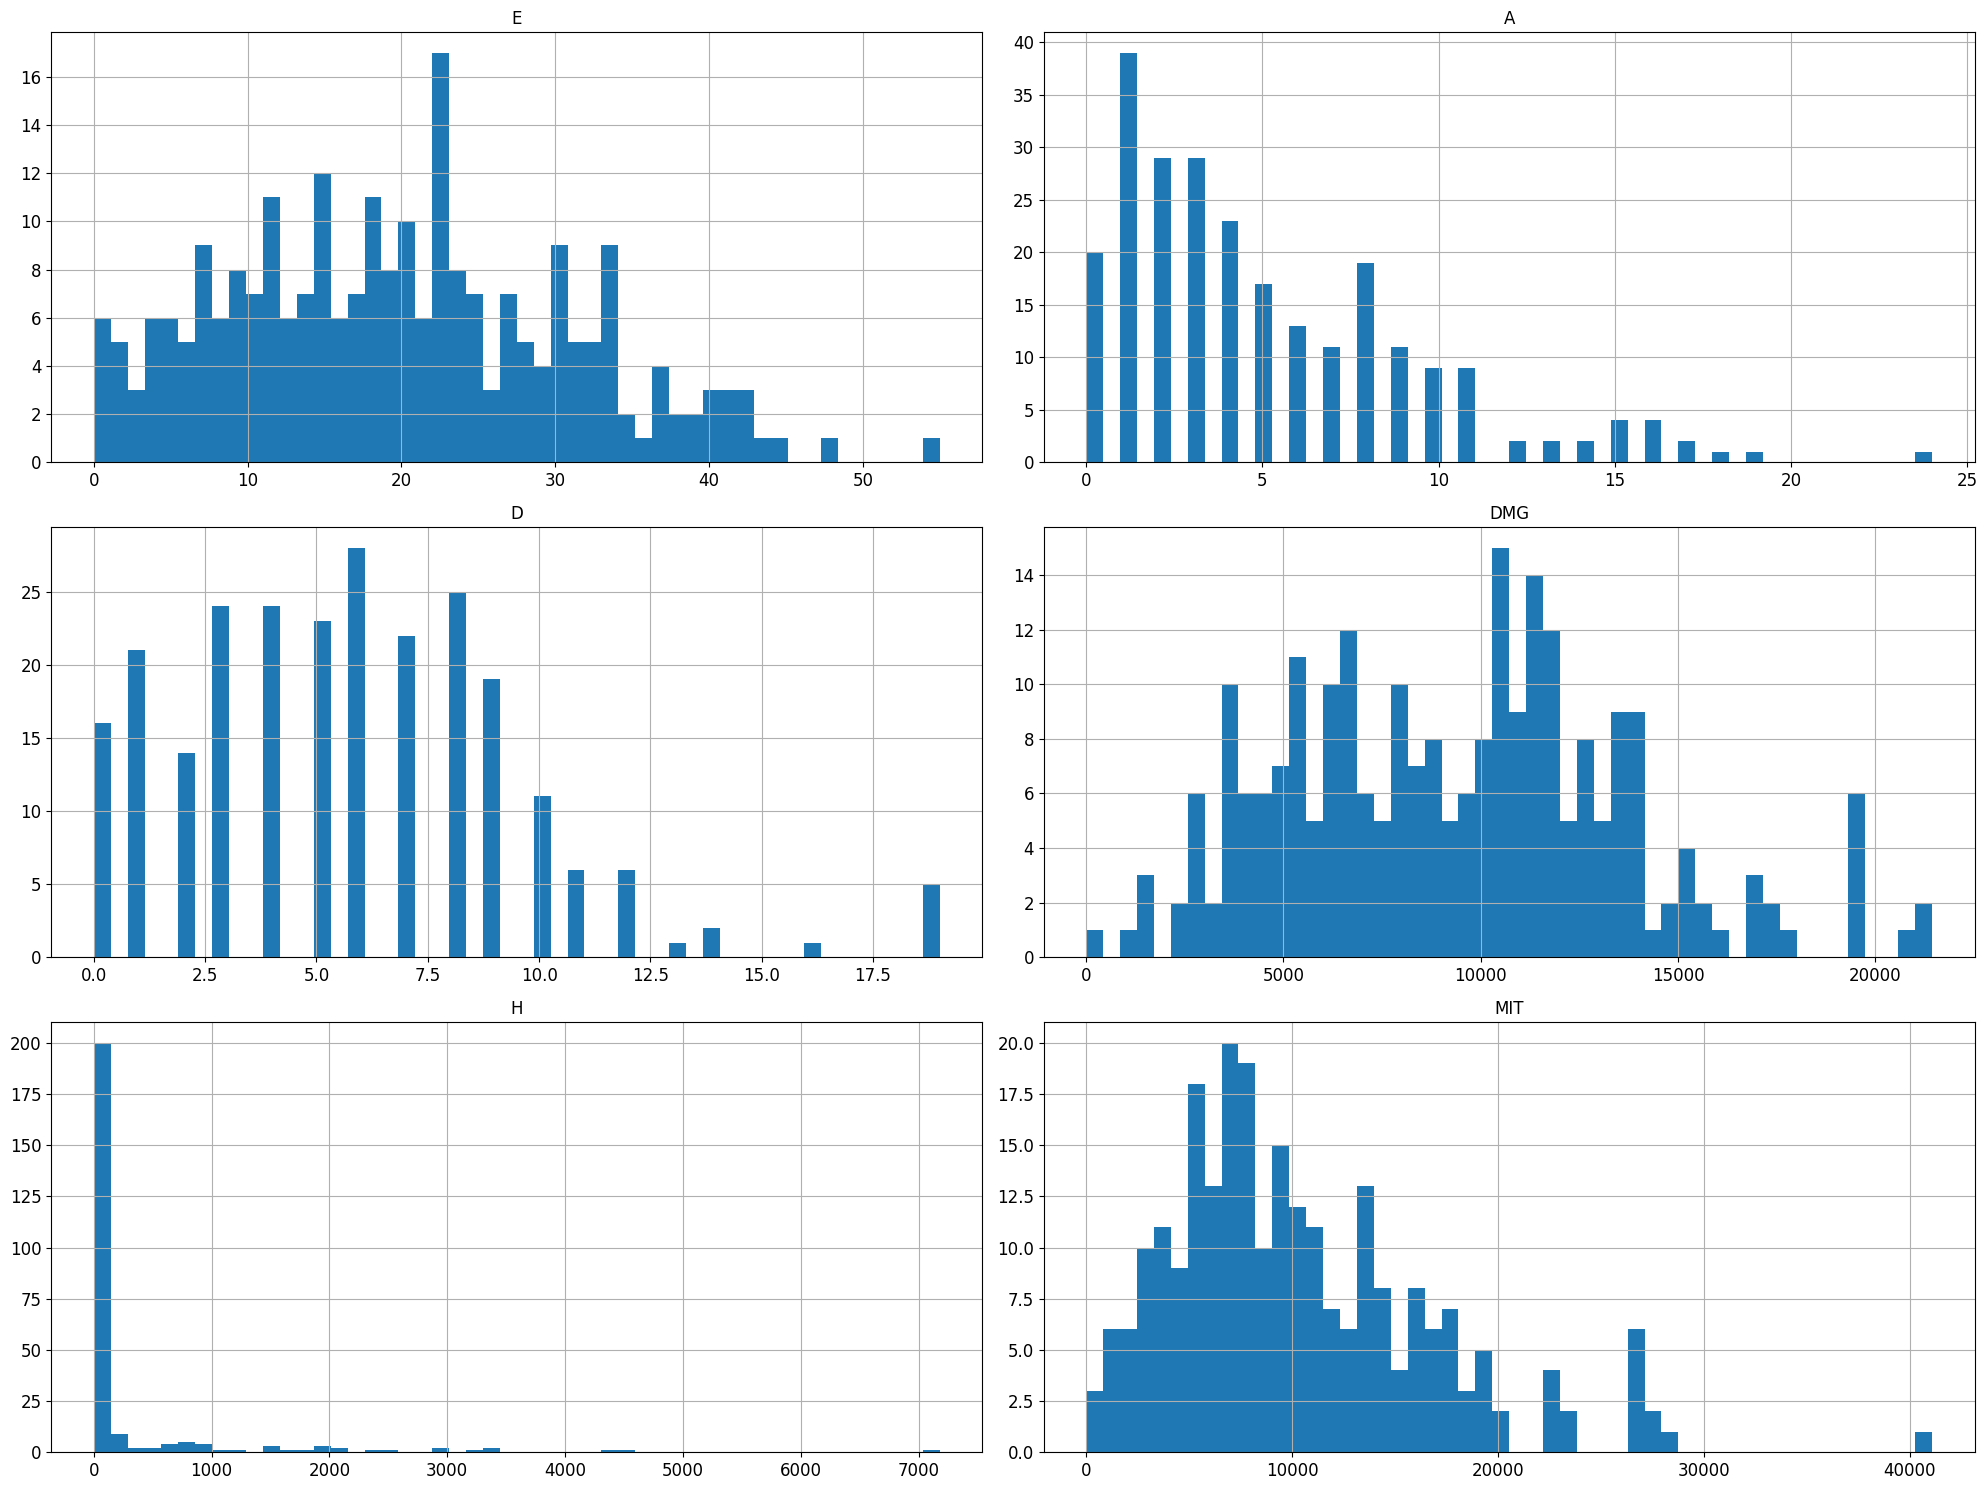

In [6]:
tank.hist(bins=50, figsize=(20, 15))
save_fig('tank_hist')
plt.show()

그림 저장:damage_hist


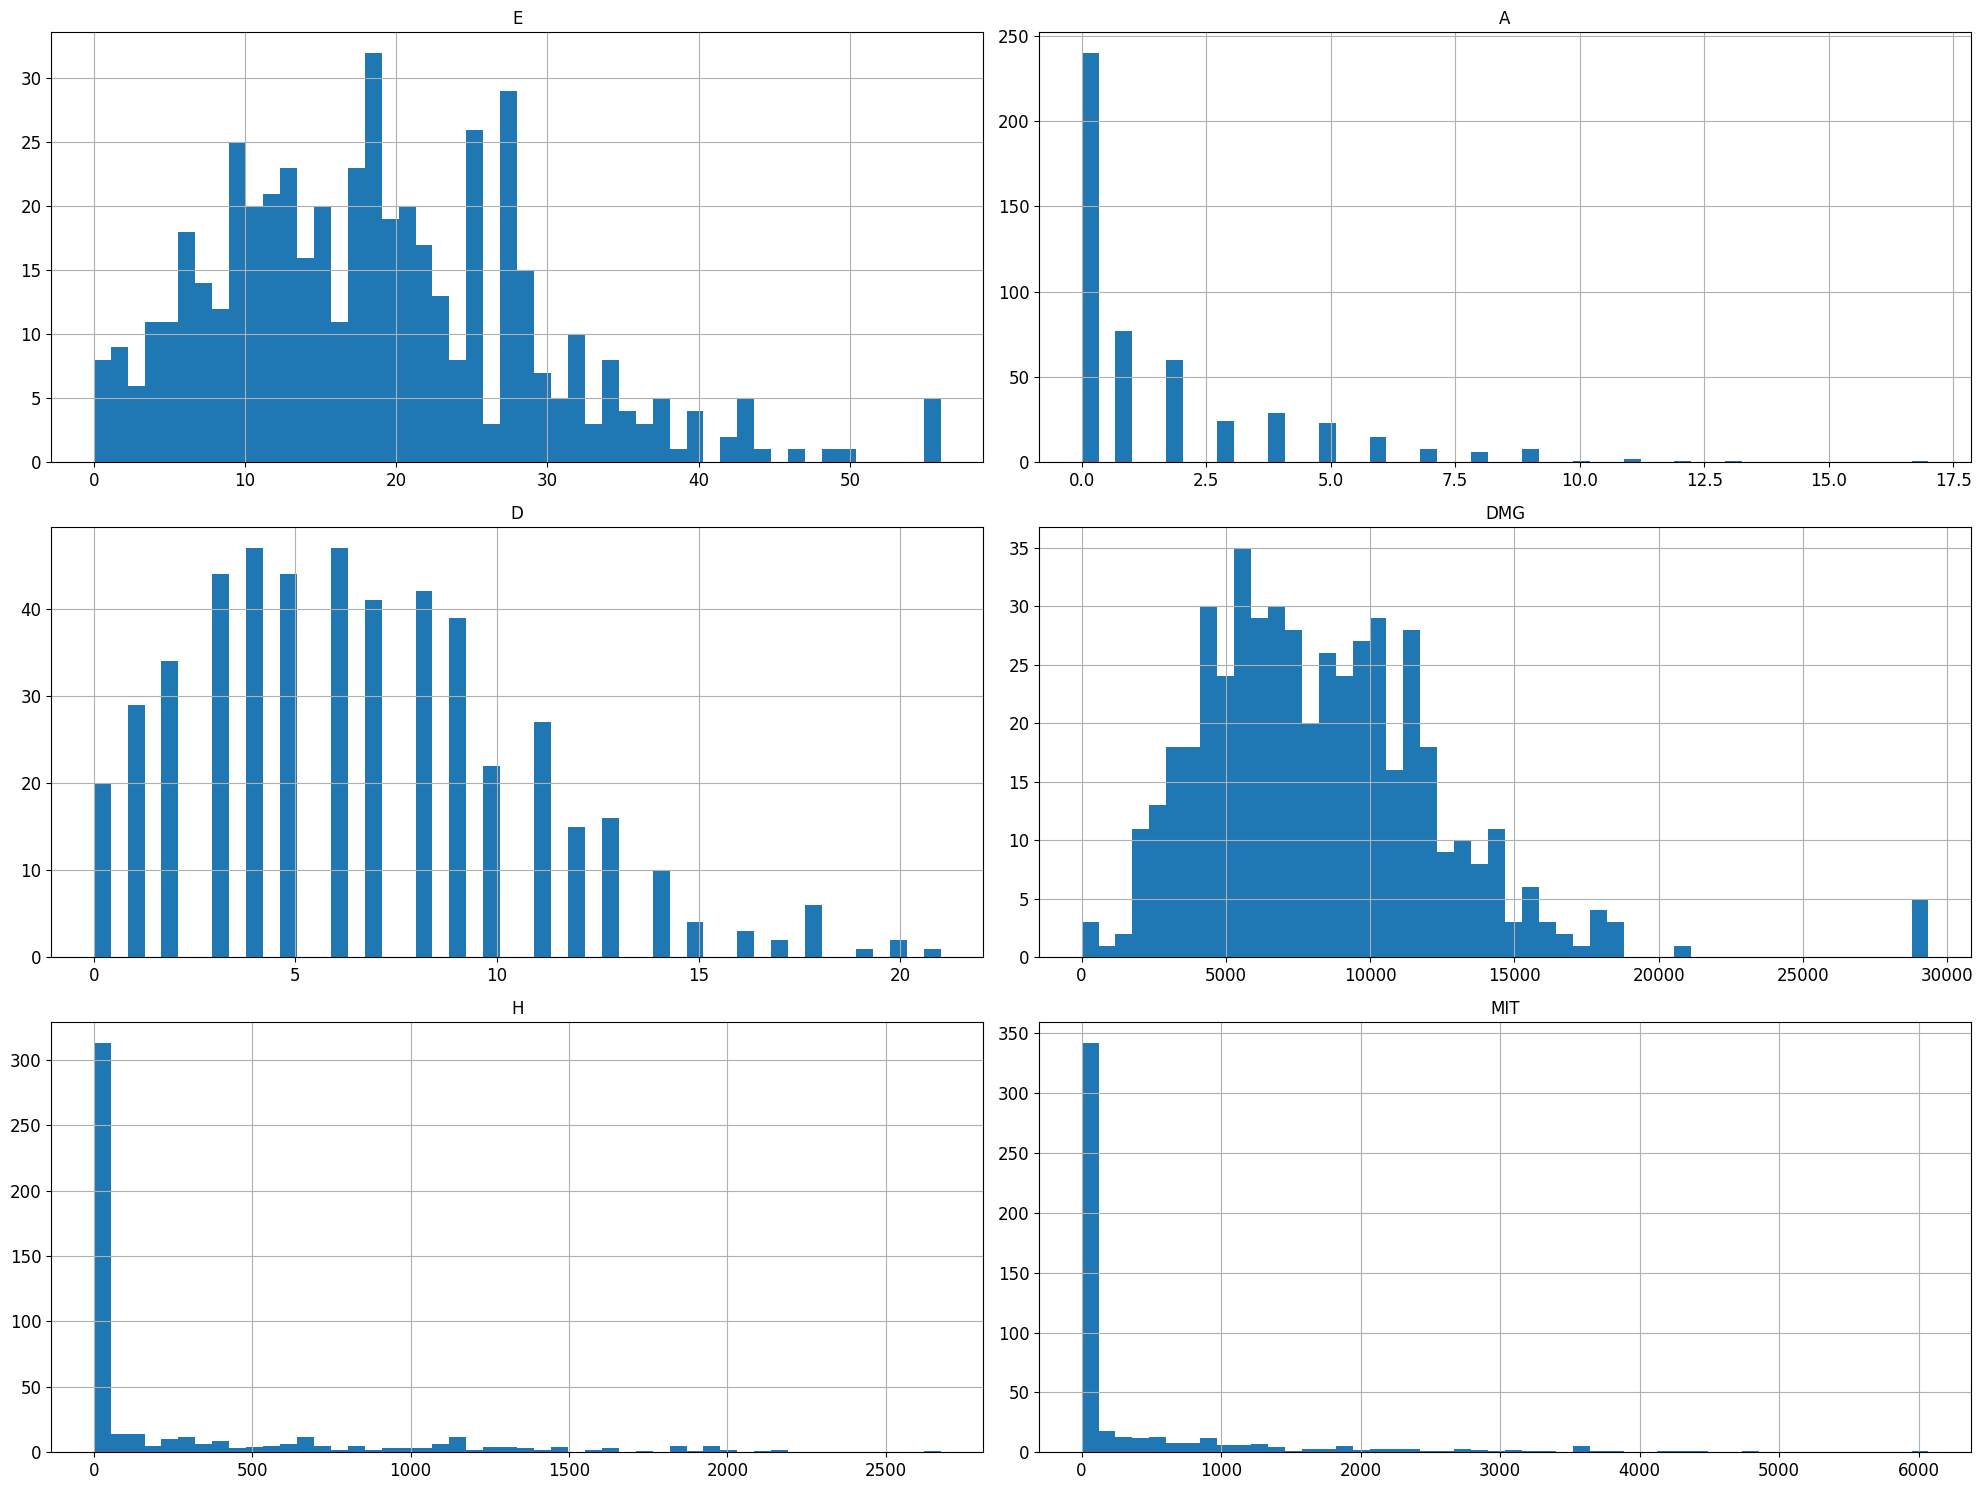

In [7]:
damage.hist(bins=50, figsize=(20, 15))
save_fig('damage_hist')
plt.show()

그림 저장:support_hist


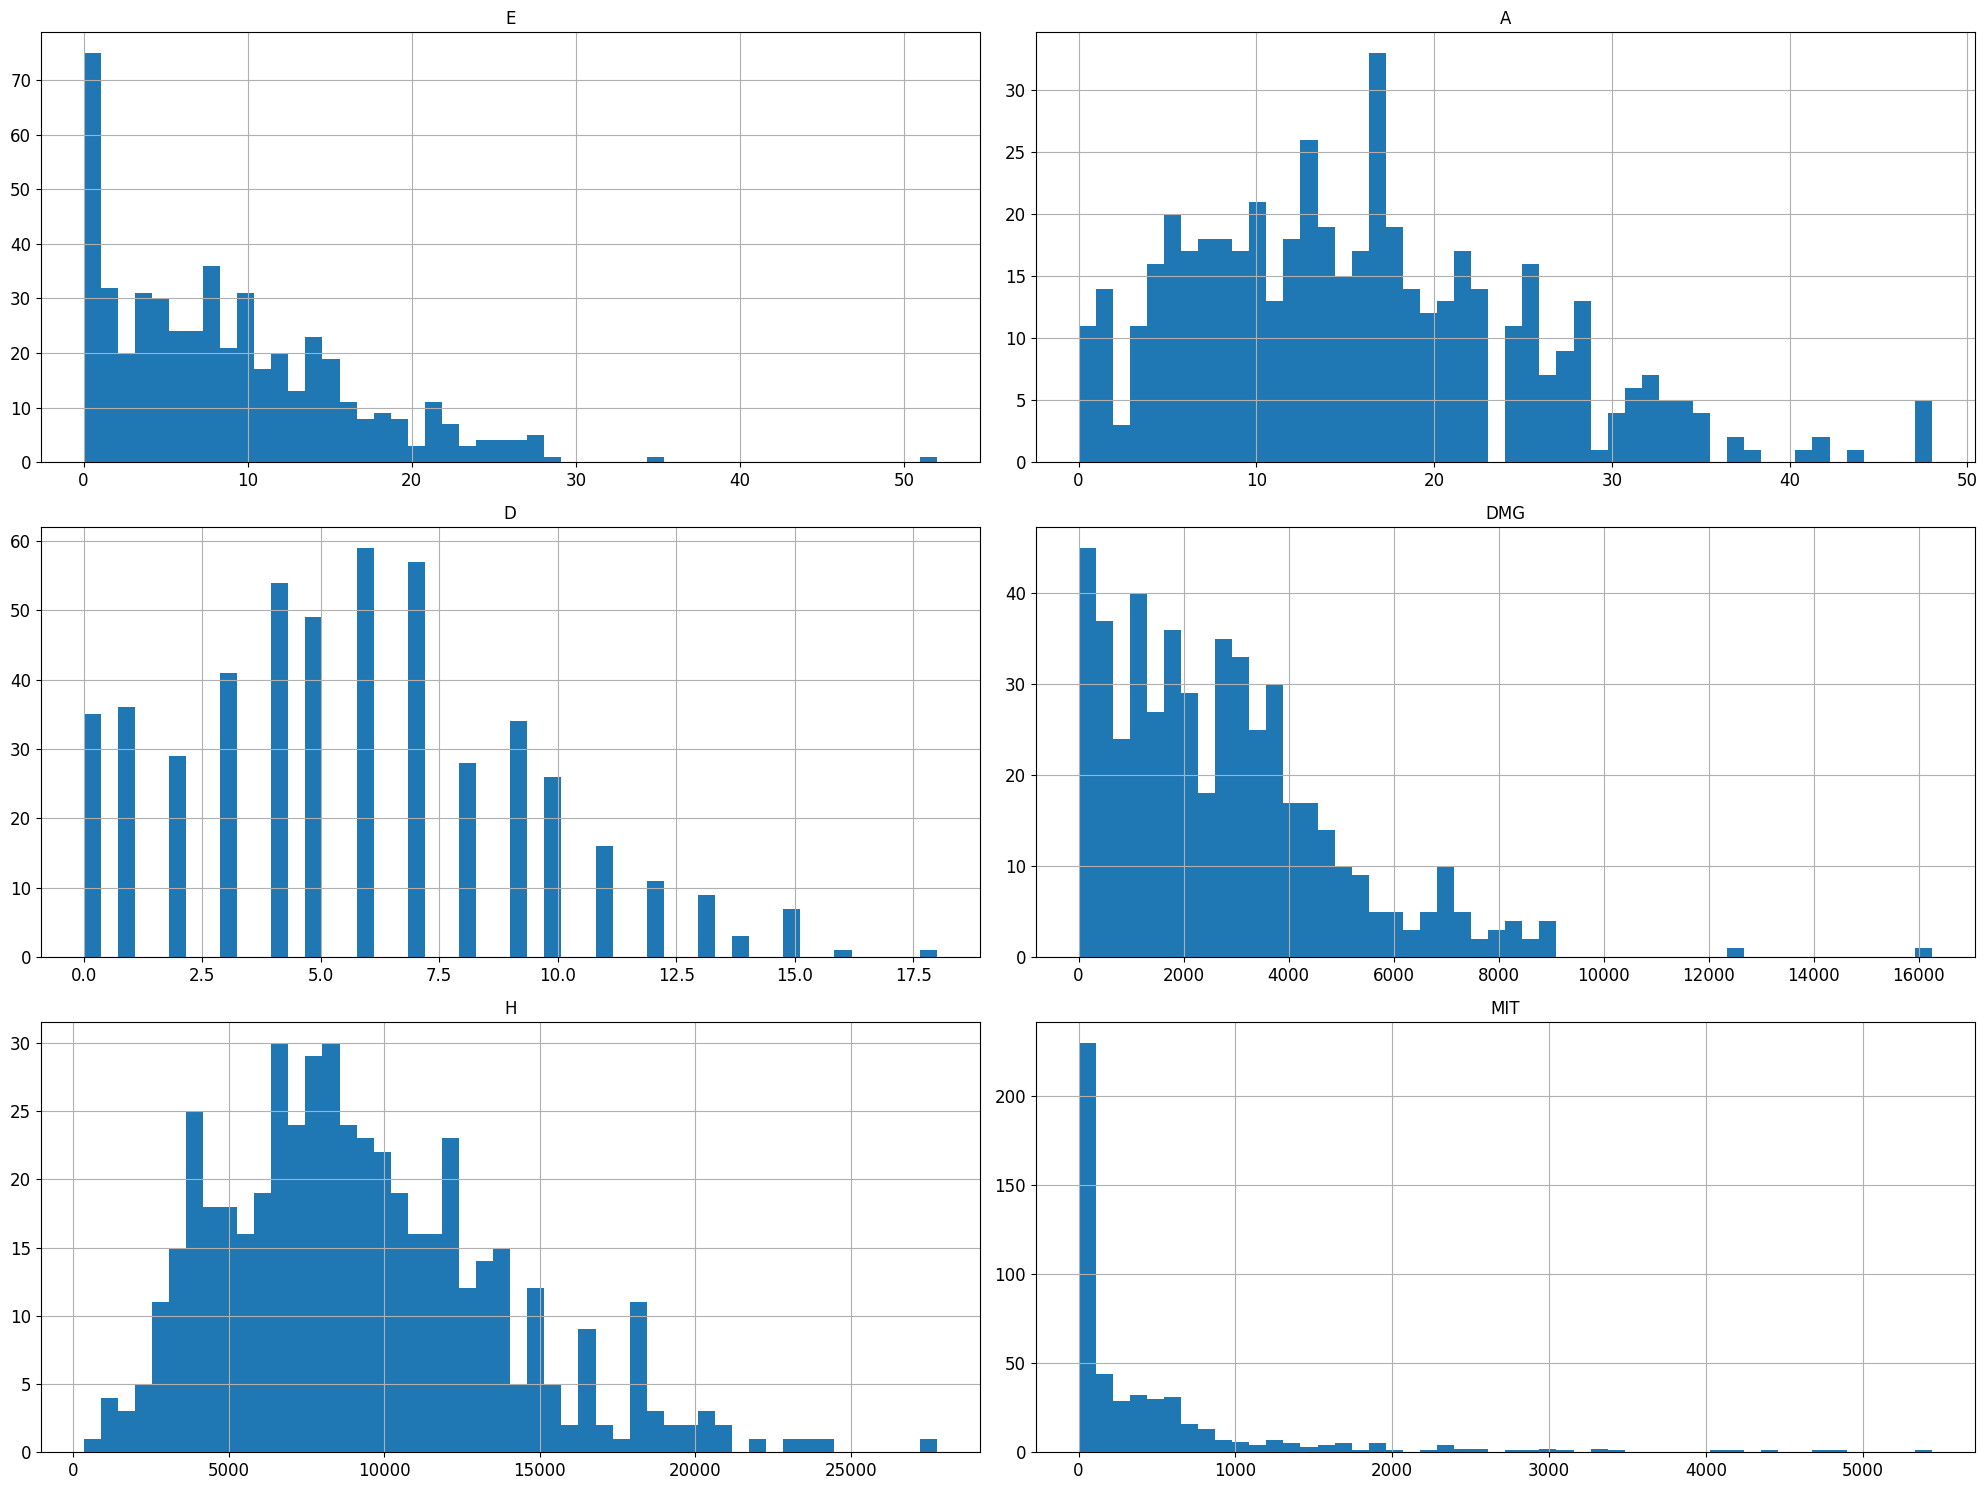

In [8]:
support.hist(bins=50, figsize=(20, 15))
save_fig('support_hist')
plt.show()

In [9]:
from sklearn.utils import shuffle

index = scoreboards.index
train_set = scoreboards.loc[shuffle(range(len(index) // players))]
train_set

E   A  D    DMG      H   MIT     GAME
169 0  28   7  3  12751   1193  3790  VICTORY
    1  25   5  5  11276      0     0  VICTORY
    2  26   3  8  10574    488   119  VICTORY
    3  12  17  4   4056   7099   304  VICTORY
    4   5  28  3   1282  12367     0  VICTORY
...    ..  .. ..    ...    ...   ...      ...
198 5  11   1  7   6404      0  9234   DEFEAT
    6   6   0  9   6783    735     0   DEFEAT
    7  13   0  8   5972      0   282   DEFEAT
    8   7   4  8   3844   7848   501   DEFEAT
    9   6   5  8   2802   9607   249   DEFEAT

[2480 rows x 7 columns]

In [10]:
scoreboards = train_set.drop('GAME', axis=1)
scoreboards_labels = train_set['GAME'].copy()

In [149]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(scoreboards)
scoreboards_tr = pd.DataFrame(X, index, scoreboards.columns)
scoreboards_tr

E         A         D       DMG         H       MIT
0   0  1.385044 -0.043326 -0.866884  1.416443 -0.517259  0.318191
    1  1.091462 -0.274648 -0.350956  1.095942 -0.748498 -0.497344
    2  1.189322 -0.505969  0.422936  0.943405 -0.653909 -0.471738
    3 -0.180726  1.113282 -0.608920 -0.472884  0.627497 -0.431929
    4 -0.865751  2.385551 -0.866884 -1.075643  1.648591 -0.497344
...         ...       ...       ...       ...       ...       ...
247 5 -0.278587 -0.737291  0.164972  0.037311 -0.748498  1.489635
    6 -0.767890 -0.852952  0.680901  0.119663 -0.606033 -0.497344
    7 -0.082866 -0.852952  0.422936 -0.056558 -0.748498 -0.436663
    8 -0.670030 -0.390309  0.422936 -0.518949  0.772676 -0.389539
    9 -0.767890 -0.274648  0.422936 -0.745364  1.113621 -0.443764

[2480 rows x 6 columns]

In [150]:
features = X.shape[-1]
X = X.reshape(-1, features * players)
X

array([[ 1.3850436 , -0.04332616, -0.86688443, ..., -1.35420687,
        -0.74849754, -0.49734419],
       [-0.47430838, -0.27464777, -0.35095609, ..., -1.35159941,
         1.84319532, -0.27958129],
       [ 0.89574045,  0.07233464,  0.16497225, ..., -0.88594951,
         1.78543416, -0.27549286],
       ...,
       [ 1.28718297, -0.15898697, -0.86688443, ..., -0.75840099,
         1.02329697,  0.00445728],
       [ 2.55937117, -0.39030857,  0.42293641, ..., -0.01179668,
         1.77496737, -0.31336467],
       [ 0.60215856, -0.50596938, -0.60892026, ..., -0.74536366,
         1.11362147, -0.44376419]])

In [151]:
X.shape

(248, 60)

In [14]:
y = scoreboards_labels[::players]
y

169  0    VICTORY
49   0     DEFEAT
186  0    VICTORY
162  0    VICTORY
191  0    VICTORY
           ...   
15   0     DEFEAT
58   0     DEFEAT
166  0    VICTORY
136  0    VICTORY
198  0    VICTORY
Name: GAME, Length: 248, dtype: object

In [15]:
y.shape

(248,)

In [16]:
from sklearn import ensemble, linear_model, neighbors, neural_network, svm, tree
from sklearn.model_selection import cross_val_score
from operator import itemgetter

estimators = (
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(n_jobs=-1),
    ensemble.ExtraTreesClassifier(n_jobs=-1),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_jobs=-1),
    ensemble.HistGradientBoostingClassifier(),
    linear_model.LogisticRegression(n_jobs=-1),
    linear_model.LogisticRegressionCV(n_jobs=-1),
    linear_model.PassiveAggressiveClassifier(n_jobs=-1),
    linear_model.Perceptron(n_jobs=-1),
    linear_model.RidgeClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(n_jobs=-1),
    neighbors.KNeighborsClassifier(n_jobs=-1),
    neighbors.RadiusNeighborsClassifier(8., n_jobs=-1),
    neighbors.NearestCentroid(),
    neural_network.MLPClassifier(),
    svm.LinearSVC(),
    svm.NuSVC(nu=.07),
    svm.SVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier()
)
scores = [(estimator, cross_val_score(estimator, X, y, n_jobs=-1).mean()) for estimator in estimators]
scores.sort(key=itemgetter(1), reverse=True)
scores

[(LogisticRegression(n_jobs=-1), 0.9029387755102041),
 (RandomForestClassifier(n_jobs=-1), 0.8990204081632653),
 (RidgeClassifierCV(), 0.8949387755102041),
 (LogisticRegressionCV(n_jobs=-1), 0.8948571428571428),
 (SVC(), 0.8907755102040816),
 (RidgeClassifier(), 0.8870204081632653),
 (GradientBoostingClassifier(), 0.8868571428571428),
 (MLPClassifier(), 0.8828571428571429),
 (Perceptron(n_jobs=-1), 0.8828571428571428),
 (ExtraTreesClassifier(n_jobs=-1), 0.8787755102040815),
 (HistGradientBoostingClassifier(), 0.8668571428571429),
 (PassiveAggressiveClassifier(n_jobs=-1), 0.8667755102040816),
 (NearestCentroid(), 0.8667755102040815),
 (KNeighborsClassifier(n_jobs=-1), 0.8666938775510203),
 (SGDClassifier(n_jobs=-1), 0.8627755102040815),
 (BaggingClassifier(n_jobs=-1), 0.8586938775510203),
 (RadiusNeighborsClassifier(n_jobs=-1, radius=8.0), 0.858530612244898),
 (LinearSVC(), 0.8546122448979592),
 (NuSVC(nu=0.07), 0.8506938775510203),
 (DecisionTreeClassifier(), 0.7985306122448981),
 (Ext

In [17]:
for estimator, _ in scores:
    estimator = estimator.fit(X, y)
    if hasattr(estimator, 'feature_importances_'):
        print(estimator)
        importances = estimator.feature_importances_.reshape(-1, features)

        tanks = importances[[0, 5]]
        damages = importances[[1, 2, 6, 7]]
        supports = importances[[3, 4, 8, 9]]

        items = '돌격 1인', '공격 1인', '지원 1인'

        print('\n**역할 중요도**')
        roles = tanks.sum(), damages.sum() / 2, supports.sum() / 2
        for s, f in sorted(zip(roles, items), reverse=True):
            print(f'{f}: {s * 100:.0f}%')

        items = '처치', '도움', '죽음', '피해', '치유', '경감'

        print('\n**특성 중요도**')
        for s, f in sorted(zip(importances.sum(0), items), reverse=True):
            print(f'{f}: {s * 100:.0f}%')
        
        print('\n**돌격 1인 특성 중요도**')
        for s, f in sorted(zip(tanks.sum(0), items), reverse=True):
            print(f'{f}: {s * 100:.0f}%')

        print('\n**공격 1인 특성 중요도**')
        for s, f in sorted(zip(damages.sum(0) / 2, items), reverse=True):
            print(f'{f}: {s * 100:.0f}%')

        print('\n**지원 1인 특성 중요도**')
        for s, f in sorted(zip(supports.sum(0) / 2, items), reverse=True):
            print(f'{f}: {s * 100:.0f}%')

        break

RandomForestClassifier(n_jobs=-1)

**역할 중요도**
돌격 1인: 31%
지원 1인: 18%
공격 1인: 17%

**특성 중요도**
처치: 34%
죽음: 26%
도움: 17%
피해: 11%
치유: 6%
경감: 5%

**돌격 1인 특성 중요도**
죽음: 12%
처치: 11%
도움: 3%
피해: 2%
경감: 2%
치유: 1%

**공격 1인 특성 중요도**
처치: 8%
죽음: 3%
피해: 3%
치유: 1%
경감: 1%
도움: 1%

**지원 1인 특성 중요도**
도움: 6%
죽음: 4%
처치: 3%
치유: 2%
피해: 2%
경감: 1%


In [18]:
importances[[0, 5]] = importances[[0, 5]].sum(0) / 2
importances[[1, 2, 6, 7]] = importances[[1, 2, 6, 7]].sum(0) / 4
importances[[3, 4, 8, 9]] = importances[[3, 4, 8, 9]].sum(0) / 4
importances

In [146]:
scoreboards_tr[10:20]

E         A         D       DMG         H       MIT
1 0 -0.474308 -0.274648 -0.350956  0.327174 -0.624253  0.315609
  1 -0.670030 -0.852952 -1.124849  0.482753 -0.748498 -0.497344
  2 -0.767890 -0.852952  0.422936  0.702432 -0.732216 -0.143587
  3 -0.865751 -0.158987 -0.866884 -0.583701  1.061869 -0.376413
  4 -0.963612 -0.274648 -0.350956 -0.544154  1.410180  0.457413
  5  0.406437 -0.390309 -0.866884  0.826938 -0.292998  0.427072
  6  0.210716  0.072335 -0.866884  1.063566 -0.600218 -0.497344
  7  0.210716 -0.621630 -0.866884  0.308704 -0.748498 -0.450004
  8 -0.767890  0.997621 -1.382813 -0.938316  1.098503 -0.481206
  9 -1.355054  1.228943 -1.124849 -1.351599  1.843195 -0.279581

In [153]:
scoreboard = X[1].reshape(players, features).copy()
print(scoreboard)
scoreboard[:, 2] = -scoreboard[:, 2]
print(scoreboard)
scoreboard = scoreboard * importances
print(scoreboard)
(scoreboard / scoreboard.sum()).sum(1)

[[-0.47430838 -0.27464777 -0.35095609  0.32717385 -0.62425289  0.31560862]
 [-0.67002964 -0.85295178 -1.12484859  0.48275262 -0.74849754 -0.49734419]
 [-0.76789027 -0.85295178  0.42293641  0.7024316  -0.73221587 -0.14358707]
 [-0.8657509  -0.15898697 -0.86688443 -0.58370079  1.06186902 -0.37641262]
 [-0.96361153 -0.27464777 -0.35095609 -0.54415423  1.41018045  0.45741272]
 [ 0.4064373  -0.39030857 -0.86688443  0.82693808 -0.29299845  0.42707224]
 [ 0.21071604  0.07233464 -0.86688443  1.06356558 -0.60021805 -0.49734419]
 [ 0.21071604 -0.62163018 -0.86688443  0.3087043  -0.74849754 -0.45000443]
 [-0.76789027  0.99762106 -1.38281276 -0.93831611  1.09850278 -0.48120564]
 [-1.35505405  1.22894267 -1.12484859 -1.35159941  1.84319532 -0.27958129]]
[[-0.47430838 -0.27464777  0.35095609  0.32717385 -0.62425289  0.31560862]
 [-0.67002964 -0.85295178  1.12484859  0.48275262 -0.74849754 -0.49734419]
 [-0.76789027 -0.85295178 -0.42293641  0.7024316  -0.73221587 -0.14358707]
 [-0.8657509  -0.1589869

array([-0.03248473, -0.08176796, -0.2065876 ,  0.024153  , -0.02120461,
        0.46574141,  0.17678432,  0.10001223,  0.29136439,  0.28398955])

In [142]:
scoreboards[10:20]

E   A  D    DMG      H   MIT
49 0   9   5  5   7738    641  3778
   1   7   0  2   8454      0     0
   2   6   0  8   9465     84  1644
   3   5   6  3   3546   9340   562
   4   4   5  5   3728  11137  4437
   5  18   4  3  10038   2350  4296
   6  16   8  3  11127    765     0
   7  16   2  3   7653      0   220
   8   6  16  1   1914   9529    75
   9   0  18  2     12  13371  1012

In [69]:
49 - len(defeat) // players - len(draw) // players + 1

-74

In [59]:
estimator = scores[0][0]
estimator

SVC()

In [18]:
estimators = (
    ensemble.AdaBoostClassifier(estimator, algorithm='SAMME'), ensemble.BaggingClassifier(estimator, n_jobs=-1)
)
for estimator in estimators:
    scores.append((estimator, cross_val_score(estimator, X, y, n_jobs=-1).mean()))
scores.sort(key=itemgetter(1), reverse=True)
scores

[(SVC(), 0.8941489361702126),
 (BaggingClassifier(estimator=SVC(), n_jobs=-1), 0.8940602836879432),
 (ExtraTreesClassifier(n_jobs=-1), 0.8900709219858156),
 (RandomForestClassifier(n_jobs=-1), 0.8858156028368794),
 (RidgeClassifierCV(), 0.8857269503546099),
 (MLPClassifier(), 0.8857269503546098),
 (GradientBoostingClassifier(), 0.8772163120567376),
 (LogisticRegressionCV(n_jobs=-1), 0.8772163120567376),
 (NearestCentroid(), 0.872872340425532),
 (PassiveAggressiveClassifier(n_jobs=-1), 0.8687943262411348),
 (LinearSVC(), 0.8685283687943264),
 (LogisticRegression(n_jobs=-1), 0.864450354609929),
 (KNeighborsClassifier(n_jobs=-1), 0.860195035460993),
 (BaggingClassifier(n_jobs=-1), 0.8562056737588651),
 (NuSVC(nu=0.07), 0.8562056737588651),
 (HistGradientBoostingClassifier(), 0.8560283687943263),
 (RidgeClassifier(), 0.8559397163120567),
 (SGDClassifier(n_jobs=-1), 0.8390070921985815),
 (Perceptron(n_jobs=-1), 0.8307624113475176),
 (DecisionTreeClassifier(), 0.8135638297872341),
 (ExtraTre

In [29]:
classifiers = []
for i in range(3, len(scores)):
    classifiers.append((i, cross_val_score(ensemble.VotingClassifier([(str(j), scores[j][0]) for j in range(i)], n_jobs=-1), X, y, n_jobs=-1).mean()))
classifiers.sort(key=itemgetter(1), reverse=True)
classifiers

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules

[(5, 0.8984042553191489),
 (3, 0.8942375886524822),
 (6, 0.8942375886524822),
 (9, 0.8942375886524822),
 (10, 0.8941489361702126),
 (11, 0.8941489361702126),
 (4, 0.8899822695035461),
 (8, 0.8899822695035461),
 (13, 0.8899822695035461),
 (15, 0.8899822695035461),
 (14, 0.8898936170212766),
 (17, 0.8898936170212766),
 (19, 0.8898936170212766),
 (16, 0.8857269503546098),
 (22, 0.8857269503546098),
 (7, 0.8856382978723405),
 (12, 0.8856382978723403),
 (18, 0.8815602836879431),
 (20, 0.8815602836879431),
 (21, 0.8814716312056736),
 (23, 0.8814716312056736)]

5개 투표가 제일 좋다.

In [ ]:
estimator = ensemble.StackingClassifier([(str(i), scores[i][1]) for i in range(2)], scores[0][1], n_jobs=-1).fit(X, y)
estimator.score(X_test, y_test)

In [ ]:
model = scores[0][1]
for i, (y_true, y_pred) in enumerate(zip(y_test.values, model.predict(X_test))):
    if y_true != y_pred:
        i = y_test.index[i][0]
        defeats = len(defeat) // players
        sum_ = defeats + len(draw) // players
        next_ = i + 1
        if i < defeats:
            print(f'{y_true} ({next_}) -> {y_pred} ({i})')
        elif i < sum_:
            print(f'{y_true} ({next_ - defeats}) -> {y_pred} ({i})')
        else:
            print(f'{y_true} ({next_ - sum_}) -> {y_pred} ({i})')
        print(test.loc[i], end='\n\n')